<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<p><p><p><p>
<b>Introduction to Rubin Image Services</b> <br>
Contact author: <i>Leanne Guy</i> <br>
Last verified to run: <i>2023-01-13</i> <br>
LSST Science Piplines version: Weekly <i>2022_24</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>intermediate</i> <br>

In [12]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

**Skills:** Learn how to use Rubin Images Services to query and retrieve images, including how to create image cutouts of variety of sizes and shapes on the different flavours of Rubin Images, e.g. single-epoch processed visit images, difference images and deep coadds.

**Description:** An introduction to Rubin Image Image Services

**LSST Image Data Products:** Single-epoch Images, Deep Coadds, Image Cutouts 

**Packages:** lsst.rsp, lsst.daf, pyvo, astropy

**Credit:** This tutorial was developed for DP0.2 by Leanne Guy.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

Rubin will deliver a range of image data products from the LSST; raw images, processed visit images (PVI), single-epoch images, deep coadded images, template images and difference images. In addition to the delivered LSST image data products, scientists will want to make their own \"created-on-demand\" images, e.g cutout images of various sizes centered about a number of positions, bespoke coadds, e.g best-seeing, deepest, etc, or PVIs with different background estimation and subtraction. <p>

Image Services is the term used to describe the collection of Rubin services used for the description, discovery, access and retrieval of LSST image data products. They include services for both image metadata and for the image pixel data itself, e.g image retrieval services, image cutout and mosiacing services, on-demand image creation services, and HiPS multi-resolution image map services. Rubin's image services are provided as part of the Rubin Science Platform's API Aspect, which are used both within the RSP to access image data products, and from externally. Rubin Observatory has adopted 'VO First' strategy for services, meaning that wherever possible, IVOA-standard interfaces will be adopted. 

- `Virtual Observatory (VO)` -- is a collection of interoperating data archives and software tools that utilize the internet to form a scientific research environment in which astronomical research programs can be conducted. It is the vision that astronomical datasets and services should work together as a whole. The VO allows scientists to query datasets at multiple data centers in a seamless and transparent way, which is made possible by the standardization of data and metadata, of data exchange methods, and by the use of a registry, which lists available services and what can be done with them. Rubin is one of many projects and data centres worldwide who are are working towards this goal. See [What is the VO](https://www.ivoa.net/about/what-is-vo.html).
  
- `International Virtual Observatory Alliance (IVOA)` -- is a global organization that facilitates the coordination and collaboration necessary to make the Virtual Observatory possible. The IVOA focuses on the development of standards and produced the \"Astronomical Data Query Language (ADQL)\". See [ivoa.net](https://ivoa.net).

A suite of VO protocols specify basic access methods for different types of data resources, e.g. catalogs, images, spectra. Tutorial 02, [Catalog Queries with TAP](https://dp0-2.lsst.io/_static/nb_html/DP02_02_Catalog_Queries_with_TAP.html), introduced the VO-compliant Table Access Protocol (TAP) service for accessing catalog (table) data and metadata. The Rubin TAP service returns structured information in a VOTable format about LSST data products and was the first IVOA-compliant service to be deployed on the RSP. In this tutorial we will introduce several new IVOA-compliant services that have been deployed as part of DP0 for accessing images and creating image cutouts.

Python access to remote data and services of the Virtual Observatory is provided by the PyVO software package

- `PyVO` -- is a software package that provides access to remote data and services of the Virtual observatory (VO) using Python. It requires both AstroPy and NumPy

### 1.1 Package Imports

In [13]:
# Import general python packages
import os
import numpy as np
import pandas as pd
import uuid
import requests
import warnings

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service

# Science Pipelines imports
from lsst.daf.butler import Butler, DatasetType, CollectionType
from lsst.afw.image import Exposure, ExposureF

# RSP utilities
from lsst.rsp import get_tap_service
from lsst.rsp.utils import get_access_token

# PyVO packages
import pyvo as vo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery
from pyvo.dal import SIAService, SIAResults

# Astropy
from astropy import units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time
from astropy.utils.data import download_file
from astropy.utils.exceptions import AstropyWarning
from astropy.visualization import  ZScaleInterval, AsinhStretch
from astropy.wcs import WCS       
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import ImageNormalize,  ZScaleInterval
from astropy.visualization.stretch import SinhStretch, LinearStretch, SqrtStretch

# Holoviz for interactive visualization
import bokeh
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import rasterize

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
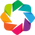

Loading BokehJS ...

In [14]:
# Set the holoviews plotting library to be bokeh and output display to be inline
hv.extension('bokeh')
output_notebook()

In [15]:
# To quiet astropy warnings
warnings.simplefilter('ignore', category=AstropyWarning) 

### 1.2 Define Functions and Parameters

In [16]:
# Set the maximum number of rows to display from pandas
pd.set_option('display.max_rows', 20)

In [17]:
# The version of the LSST science pipelines should match the verified version listed at the start of the notebook
! echo ${IMAGE_DESCRIPTION}
! eups list lsst_distrib

Weekly 2024_16
   g4213664e8e+c2911b1728 	current w_2024_16 setup


In [18]:
# Create an output directory for data
path = os.path.join("./data", "dp02_xx")
try:
    os.makedirs(path, exist_ok=True)
    print(f"Directory '{path}' created successfully.")
except OSError as error:
    print(f"Error creating directory '{path}': {error}")

Directory './data/dp02_xx' created successfully.


In [19]:
def is_valid_uuid(val) -> bool:
    """Convert a  string to a valid UUID
    
   Parameters
    ----------
    val : `string`
        the stringt o convert to check
        
   
   Returns
    -------
    uuid : `uuid.UUID` 
        A valid UUID
    """
    try:
        return uuid.UUID(str(val))
    except ValueError:
        return None

In [20]:
def transformAndPlotImage(image: Exposure, title = None, img_opts: dict = None):
    """Plot and image using holoviews
   
   Parameters
    ----------
    image : `Exposure`
        the image to plot
        
    opts : `
   
   Returns
    -------
    title : `str` (only if result is not `None`)
        Plot title from string
    """
    arrayData = image.image.array
    
    # Apply a asinh/zscale mapping to the data    
    transform = ZScaleInterval() + AsinhStretch()
    
    scaledArrayData = transform(arrayData)
    scaledFlippedArrayData = np.flipud(scaledArrayData)    
    bbox_img = image.getBBox()
    bounds_img = (bbox_img.endX, bbox_img.endY,bbox_img.beginX, bbox_img.beginY)
    
    # Define some default plot options for the Image if not passed
    if img_opts is None:
        img_opts = dict(height=600, width=700,  xaxis="bottom", 
                        padding = 0.01, fontsize={'title': '8pt'},
                        colorbar=True, toolbar='right', show_grid=True,
                        tools=['hover']
                   )
    # Overlay the WCS - not complete
    wcs = image.getWcs()
    projection=WCS(image.getWcs().getFitsMetadata())
    
    # Create the Image element.
    img = hv.Image(scaledFlippedArrayData, 
                   bounds=bounds_img, 
                   kdims=['x', 'y']).opts(
        cmap = "Gray",  xlabel = 'X', ylabel ='Y',  title = title, **img_opts)
    # img = img.redim.range(z=(0.3, 0.8))
    return rasterize(img)

In [21]:
# # Write data to file 
# # Write the results to a VOTable python 
# resultset.votable.to_xml(os.path.join(path,"resultset_votable.xml"))
# resultset.to_table().write(os.path.join(path, "resultset_format_votable.xml"), format='votable', overwrite=True)

# #Write the results to FITs file  
# resultset.to_table().write(os.path.join(path, "filename.fits"), format='fits', overwrite=True)

NameError: name 'resultset' is not defined

In [ ]:
for vo_service in vo.regsearch(datamodel='obscore'):
    print(f"{vo_service['short_name']},  {vo_service['ivoid']}")  

## 2. Data Discovery

Table Access Protocol (TAP) defines a service protocol for accessing tabular data, such as astronomical catalogues. The Rubin TAP Service has been in use since DP0.1 and was the first VO-compliant service to be deployed.  It allows users to query the DP0 catalogs, filtering on attributes to retune a subset of the catalog entries for further analysis,  e.g select all Objects in a given search area with magnitude < 18. Many catalog queries executed over TAP specify make use of the IVOA specification for a [Simple Cone Search](https://ivoa.net/documents/ConeSearch/20200828/WD-ConeSearch-1.1-20200828.html) for retrieving records from astronomical catalogs whose positions lie within a cone defined by a central position and angular radius. The returned result set type is a [pyvo.dal.TAPResults](https://pyvo.readthedocs.io/en/latest/api/pyvo.dal.TAPResults.html#pyvo.dal.TAPResults), which holds the list of matching records from a catalog query. `TAPResults` is essentially a wrapper around an [astropy.io.votable](https://docs.astropy.org/en/stable/io/votable/ref_api.html#module-astropy.io.votable) [TableElement](https://docs.astropy.org/en/stable/api/astropy.io.votable.tree.TableElement.html#astropy.io.votable.tree.TableElement) instance where the columns contain the various metadata describing the entries. 

* `IVOA Table Access Protocol (TAP)` -- a IVOA-standard service protocol for accessing general tabular data, including astronomical catalogs and their metadata. 
* `IVOA Simple Cone Search (SCS)` --  a simple query protocol for retrieving records from an astronomical catalog or observation log. The input is sky position and angular distance defining a cone on the sky. The subset of records from the catalog that lie within the cone is returned. This protocol is easy to use but scales poorly since a separate query is required for every position. See [IVOA Simple Cone Search](http://www.ivoa.net/Documents/latest/ConeSearch.html)

<!-- * `TAP Service` -- a service that implements TAP to allow users to interogate to catalogs data using ADQL and SQL-like queries. -->

Initial priority was given to rolling out services implementing the above to enable access to catalog data described in the DPDD and produced by the LSST science Pipelines. This was to enable the Rubin community to gain experience with the data products described in the DPDD.  Another strongly motivating use case is the ability to discover data of a given kind, e.g images, catalogs, spectra, according to scientific criteria, e.g position, exposure time, seeing, etc. 

The returned result set type is a [pyvo.dal.TAPResults](https://pyvo.readthedocs.io/en/latest/api/pyvo.dal.TAPResults.html#pyvo.dal.TAPResults), which holds the list of matching records from a catalog query. `TAPResults` is essentially a wrapper around an [astropy.io.votable](https://docs.astropy.org/en/stable/io/votable/ref_api.html#module-astropy.io.votable) [TableElement](https://docs.astropy.org/en/stable/api/astropy.io.votable.tree.TableElement.html#astropy.io.votable.tree.TableElement) instance where the columns contain the various metadata describing the entries. 

We will see later that it can also hold lists of matching records from an image query or a query of the observatry metadata.

There are many functions we can eecute without having to convert to pandas

prioritised IVOA-standard-compliant implementations of the TAP and SCS services ...

The tap acessoble catalog describe the data prodicts as processed. but we also want to query on for example spatial resolution of the image. 

This tutorial will introduce the next suite of IVOA-compliant services that have been deployed by Rubin as part of DP0 to enable data discovery and prodicing image cutouts on demand. It will introduce several new IVOA-compliant services for data doscovery and image access and manipulation incliding ObsCoer, ObsTAP, Datalinks and SODA. One key consideration is the ability to execute the same query at multiple archives. we will look at some examples. 

In [ ]:
# Instantiate a DP0.2 TAP service 
service = get_tap_service("tap")
assert service is not None

### 2.1 The Rubin Observation Data Model

TAP services provide information on the various schemas and tables they contain in a special table named `TAP_SCHEMA`. The  `tap_schema.schemas` table lists all the schemas hosted in the RSP. 

In [ ]:
Which tables can I query via the TAP service
SELECT schema_name, table_name, description
FROM TAP_SCHEMA.tables
ORDER BY schema_name, table_name

-- Further details:
-- All TAP services must support a set of (meta) tables, in a schema named TAP_SCHEMA.
-- These meta-tables describe all tables and columns published through the TAP service.
-- The meta-tables can be queried themselves via TAP.
-- Users can discover ESO-published tables or columns by querying the tables in this schema

In [ ]:
query = """
SELECT * FROM tap_schema.schemas
"""
results = service.search(query).to_table()
results

The `dp01_dc2_catalogs` and `dp02_dc2_catalogs` schemas contain the tables of Rubin data products, e.g. Object, ForcedSource, Visit, etc.  The other three schemas contain IVOA-defined standard tables that contain metadata related to a service: <br>

- `tap_schema`  metadata related to the TAP service, e.g  tables and columns exposed, indexing, descriptions and other information about columns.  All TAP services must support a set of tables in a schema named TAP_SCHEMA that describe the tables and columns included in the service.
- `ivoa` metadata related to the Observation data model for Rubin datasets, useful for data discovery  
- `UWS` metadata related to the Universal Worker Service (UWS) pattern for managing asynchronous execution of jobs on a service.

Tutorial [NB 02. Catalog Queries with TAP](https://dp0-2.lsst.io/_static/nb_html/DP02_02_Catalog_Queries_with_TAP.html) explores the `tap_schema`. In this tutorial we will explore the `ivoa` schema, which holds the `ivoa.ObsCore` table containing generic metadata for the datasets held at the US Data Access Center (US DAC). The table is accessible via ADQL queries via a TAP endpoint.

The IVOA maintains a registry of all VO compliant services. We can interrogate this registry to find all the Tap services that support the ObsCoreDM. Valid registry keywords incluide: author, datamodel, ivoid, keywords, servicetype, spatial, spectral, temporal, ucd, waveband.

In [ ]:
query = """
SELECT * FROM tap_schema.tables where schema_name like 'ivoa' order by table_index ASC
"""
result = service.search(query).to_table()
result

In [ ]:
What are the column names of the ObsCore table?
SELECT column_name, datatype, unit, ucd, utype
from TAP_SCHEMA.columns
where table_name='ivoa.ObsCore'


The `ivoa` schema holds one table,  the`ivoa.ObsCore` table, which contains generic metadata for all datasets held at the US DAC.
Observation Data Model Core Components and its Implementation in the Table Access Protocol (ObsCore)	https://www.ivoa.net/documents/ObsCore/20111028/


Here are some definitions to help understand the description of this schema: 
* `ObsCore` - Observation Core components. Metadata for the discovery of data via an IVOA-standard-compliant TAP service, such as the Rubin TAP service. It describes the core components and the metadata to be attached to an astronomical observation,primarily describes data products by the physical axes (spatial, spectral, time, and polarization).ObsCore Data Model, 
* `ObsCoreDM` - Observation Core components Data Model. A data model that primarily describes data products by the physical axes (spatial, spectral, time, and polarization).
* `ObsTAP` - TAP interface to an Observation Data Model.

An ObsCore table may contain a) optional ObsCore-defined columns, and/or b) additional service-specific columns.
  
ObsTAP and the observation data model describe observations in a broad sense (exactly what comprises an "observation" is not well defined within astronomy and is left up to the data provider to define for their data).  In general an "observation" may be composed of multiple individual data products. ObsTAP also describes archive data products (e.g., actual archive files).


Let's take a look at how to query the ObsCore table. We will start by looking at the table collections (schemas) present. In addition to the DP0.1 and DP0.2 catalog and TAP schema that were present in DP0.1, you will now see a new schema called "ivoa".

We will look at the ObsCore Data Model and explore some of the most common informatin fileds that people will want to use.

IVOA prescribes a set of Core Components of teh Observation data model -- a set of colums that must be included within teh `ivoa.ObsCore` table and a data center's data model. On top of those, dta centers can add dataset/survey specific columns

We will take a look at the LSST ObsCore Data Model (ObsCoreDM) and how to query it using the ObsTAP service. 
We will then look at how to download data products.

which contains a table called ivoa.ObsCore. 
The IVOA-defined obscore table contains generic metadata for datasets held at the IDF. 
The table is accessible via ADQL queries via a TAP endpoint. 
The mechanism for locating images from obsevations is to make a TAP query against the ObsCore schema.

Let's use the TAP service to look at the tables in the ivoa table collection.  
The ivoa schema contains 1 table called \"ivoa.ObsCore\". This table holds the observation metadata for all images in the DP0.2 dataset. Let's look a the main concepts in the ObsCore data model. 

The IVOA-defined obscore table, containing generic metadata for datasets within this datacenter.  The table is accessible via ADQL queries via a TAP endpoint.

The ObsCore data model that we see above results from analysis carried out by the IVOA to support global data discovery and accessibility. Many of the columns are a mandatory fields of the Observation Core Components data model including their name, recommended units, data type and designation.

In [ ]:
# Let's take a look at the metadata about images that is contain in the Rubin ObsCore table
query = """SELECT *
  FROM tap_schema.columns
  WHERE table_name = 'ivoa.ObsCore'
"""
result = service.search(query).to_table()
result[result.colnames[3:12]]

- `dataproduct_type` : The data product type, e.g  Image, Spectrum, SED
- `dataproduct_subtype`: The dataproduct subtype, e.g PVI, coadd, difference image
- `calib_level`: The calibration level indicating the amount of calibration processing that was applied to create the data product. 

### 2.2 Data Discovery using ObsCore 

Let's look at some examples of how we can use the metadata about Rubin images in the ObsCore table ObsCoreThe Rubin ObsCore table holds the observation metadata for all images in the DP0.2 dataset. Let's explore the contents of the ObsCore table. 

#### 2.2.1 Discovery by data product type

The model defines a data product type attribute. This is the observation product that a user will query for an retrieve, e.g \"image\", \"spectrum\". There is currently only one data product type supported in the Rubin ObsCore DM -- \"image\".  DP0.2 also has only one `facility_name`, `instrument_name` and `obs_collection`. So for DP0.0, including filters on these fields does not do anything, and you can safely omit them. Rubin however has several instruments, `AuxTel`, `ComCam`, `LSSTCam` so when real data arrives, will have more values. 

In [ ]:
query = """ 
SELECT dataproduct_type, facility_name, instrument_name, obs_collection, COUNT(*) 
FROM ivoa.ObsCore 
GROUP BY dataproduct_type
"""
result = service.search(query).to_table()
result

In addition to the data product type, there are five unique data product subtypes defined in the ObsCore table. The data product subtype allows us to be more specific about data product type. Let's take a look at the data products defined in the Rubin ObsCore DM. 

In [ ]:
query = """ 
SELECT dataproduct_type, dataproduct_subtype, COUNT(*) 
FROM ivoa.ObsCore 
GROUP BY dataproduct_subtype
"""
result = service.search(query).to_table()
result

The calibration level tells the user the amount of calibration processing that was applied to create the data product. -  cannot be null for any entry in the ObsCore table. The following goves the defined calib_levels and their relationship to the LSST data products.
cannot be null for any entry in the ObsCore table. The following goves the defined calib_levels and their relationship to the LSST data products. 

- `0`:  raw instrumental data, possibly in proprietary internal provider format
- `1`: instrumental data that may or may mot be calibrated in standard format -- lsst.raw
- `2`: science-ready calibrated data with instrument signature removed -- lsst.calexp
- `3`: enhanced science-ready data products, e.g mosaics, coadds, difference images -- lsst.deepCoadd_calexp, lsst.goodSeeingDiff_differenceExp, lsst.goodSeeingCoadd

In [ ]:
query = """ SELECT  dataproduct_type, dataproduct_subtype, calib_level, COUNT(*) 
FROM ivoa.ObsCore 
GROUP BY dataproduct_subtype, calib_level
ORDER BY calib_level
"""
result = service.search(query).to_table()
result

[dp0-2.lsst.io](https://dp0-2.lsst.io/data-products-dp0-2/index.html) lists many more data product types that are not listed here. For example, "deepCoadd" is not listed and you will not find any deepCoadd data product in the ObsCore table. Need to investigate. 

#### 2.2.2.Discovery by spatial coordinates 

The ObsCore model also defines a region with the `s_region` column expressed in the ICRS frame. We can use this attribute to select  image data products that fall into a given region, and then add additional filters.

In [ ]:
# Define a position and angular radius for the search 
center_coords = SkyCoord(55.74673760481304, -32.286155241413624, frame='icrs', unit='deg')
ang_radius = 10*u.deg

In [ ]:
# Why does s_region come back with a POLYGON when I specify a CIRCLE?
query_template = """
SELECT *
FROM ivoa.ObsCore
WHERE 1=CONTAINS(
  POINT('ICRS', ivoa.ObsCore.s_ra, ivoa.ObsCore.s_dec),
  CIRCLE('ICRS', {ra}, {dec}, {radius})
) 
"""
query = query_template.format(ra=center_coords.ra.deg, 
                              dec=center_coords.dec.deg, 
                              radius=ang_radius.value)
result = service.search(query).to_table()
print(len(result))

That's a lot of images in a 0.1 deg field. We can add some more filters 

In [ ]:
query_deep_coadd = query_template.format(
    ra=center_coords.ra.deg, 
    dec=center_coords.dec.deg, 
    radius=0.15) 
query += str("""AND dataproduct_type = 'image' 
    AND obs_collection = 'LSST.DP02' 
    AND dataproduct_subtype = 'lsst.deepCoadd_calexp'
    AND lsst_band='r'
    """)
results = service.search(query_deep_coadd)
results.to_table()

We see that there are 6 deepCoadd_calexp images, one for each filter. Alternatively, knowing the patch and tract, can query directly for the same images and specify a filter. 

In [ ]:
query = """SELECT * FROM ivoa.ObsCore 
WHERE dataproduct_type = 'image'
AND obs_collection = 'LSST.DP02' 
AND dataproduct_subtype = 'lsst.deepCoadd_calexp'
AND lsst_tract = 4431
AND lsst_patch = 17
AND lsst_band = 'i'
"""
results = service.search(query)
results.to_table()

In [ ]:
# Let's search for the image that contains the SN1a used in tutorial 7a. 
query = """SELECT * FROM ivoa.ObsCore 
WHERE dataproduct_type = 'image'
AND obs_collection = 'LSST.DP02' 
AND dataproduct_subtype = 'lsst.deepCoadd_calexp'
AND lsst_tract = 4431
AND lsst_patch = 17
AND lsst_band = 'i'
"""
diaObjectId = 1250953961339360185


2.2.2.X  Query products by filter, sorting by declination

### 2.3 Data Access using the DataLink Links Service

Now that we know how to query the ObsCore table to find images, lets see how to access them. We will use the i-band image in tract 4431, patch 17 that we queried for above as an example. The information needed to access the image data product is provided by the \"access_url\" and \"access_format\" columns. 

* `DataLink` - An IVOA standard to link from metadata about a dataset to the dataset itself, as well as other related data and services that can operate on that data. This is new and we will lok at it in this tutorial
* `SODA`
* `SIA` -- want to intriduce this now as a concept


* `access_url` - column that contains a URL for each observation with a retrievable image. 
* `access_format` - specifies the format (content type) of the data product. 

The `access_url` format is `<rsp-base-url>/api/datalink/links?ID=<id>` where `<rsp-base-url>` is the base URL of the instance of the Rubin Science Platform and `<id>` is a unique identifier (UUID) for the image in the Butler. Note that if an observation listed in the ObsCore table does not have a corresponding retrievable image, `access_url` will be null. 
 
The `access_format` specifies the format of the URL in the `access_url` column. It is set to `application/x-votable+xml;content=datalink` to indicate that the `access_url` is a [DataLink](https://www.ivoa.net/documents/DataLink/) service. DataLink is an IVOA data access protocol that provides a linking mechanism metadata about a dataset and the dataset itself. Storing non-tabular data such as images and spectra in tables in a relational database is impractical. Instead we use the dedicated DataLink service designed to handle large volumes of requests to host these datasets. 

Let's get the DataLink URL for the i-band image in tract 4431, patch 17. Note that we can use the method `getdataurl` to get the URL in the `access_url` field.

In [ ]:
dataLinkUrl = results[0].getdataurl()
f"Datalink link service url: {dataLinkUrl}"

Extract the UUID for the image from the DataLink URL.

In [ ]:
image_uuid = uuid.UUID(dataLinkUrl.split("dp02/",1)[1])
assert isinstance(image_uuid, uuid.UUID)
f"UUID for i-band image tract 4431, patch 17 is: {image_uuid}"

Let's check that the UUID extracted from the DataLink URL coresponds to the same data product from the Butler

In [ ]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry
dataId = {'band':'i', 'tract':4431, 'patch': 17}
datasetRef = registry.findDataset('deepCoadd_calexp', dataId)
deepCoadd_uuid = datasetRef.id
assert deepCoadd_uuid == image_uuid
f"UUID for deep coadd with dataId {dataId} is {deepCoadd_uuid}"

Alternatively, if we know the UUID for a data product, we can use it to query the ObsCore table directly as follows.

In [ ]:
query = """
SELECT access_url, dataproduct_subtype, lsst_patch, lsst_tract, lsst_band
FROM ivoa.ObsCore 
WHERE access_url like '%20d28216-534a-4102-b8a7-1c7f32a9b78c' 
"""
results = service.search(query)
assert len(results) == 1  
results.to_table()

Now that we know have the DataLink URL for our image, let's see how to access it. Before proceeding however, we need to extract the session authentiction for reuse. 

In [ ]:
auth_session = service._session

We will use the PyVo `DatalinkResults` class to return a list matching records, each record containing a set of metadata describing the record.

In [ ]:
dl_results = DatalinkResults.from_result_url(dataLinkUrl,session=auth_session)
f"{dl_results.status}"

In [ ]:
dl_results.to_table().show_in_notebook()

In the table above we see that two records are returned for our image. The first is a signed URL for the image (Primary image or observation data file) that is valid for one hour. ADD some text explaning where the image is stored and the URL. The second is a link to the cutout service.

DataLinks return results: In addition to providing a link to the image, we also want to provide pointers to associated services, in this case,  to a SODA-compliant image cutout service. Attaching the image cutout service descriptor the the DataLinks links service is a simple and convienient way to keep all the metadata about the image together.  Additionaly, this will allow us, for example, to point a future SIA service at the same DataLink links service and thus easily provide the same service descriptors.

We will look at the cutout service in part 4 of this tutorial. First, we will use the signed URL to visualise the image

In [ ]:
image_url = dl_results.getrecord(0).get('access_url')
f"{image_url}"

We can plot the image by making an Exposure object directly from the URL. Let's plot this image side by side the image retrieved via the Butler

In [ ]:
image_datalink = ExposureF(image_url)
image_butler =  butler.get('deepCoadd_calexp', dataId=dataId)

In [ ]:
img_opts = dict(height=300, width=350, xaxis="bottom",
                padding=0.05, fontsize={'title': '8pt'},
                colorbar=False, toolbar=None, show_grid=False, 
                tools=[])

In [ ]:
dl_image = transformAndPlotImage(image_datalink, "Image from ObsCore", img_opts) 
butler_image = transformAndPlotImage(image_butler, "Image from Butler", img_opts)
layout = hv.Layout(dl_image + butler_image).cols(2)
layout

### 2.3 Inspecting and Downloading Images

We can open the image and inspect the header information witout downloading the image. The image is clearly a coadd. We can download the image using 
the astropy utility function `download_file` that downloads a file from a URL and optionally caches the result.  

In [ ]:
hdulist = fits.open(image_url)
for hdu in hdulist:
    print(hdu.name)

In [ ]:
filename = download_file(image_url, cache=True, timeout=120, show_progress=False)
assert os.path.isfile(filename)
f"Downloaded image to {filename}"

We can inspect the header information 

In [ ]:
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header
wcs = WCS(hdr)

Or just plot the image directly by creating an `ExposureF` object

In [ ]:
image_download = ExposureF(filename)
transformAndPlotImage(image_download, "Downloaded image", img_opts)

X. Image Services

Image servies are base on the ObsCore observatin metadata service IVOA-standard-compliant implementation of the SODA image cutout service

## 3 The Rubin Image Cutout Service 

When working with astronomical images, it is often desireable to work with only a cutout of a larger image, centered on a region of interest, for example a star cluster or supernova. Rubin provides an `Image Cutout Service` that can be used to create and retrieve cutouts of defined regions of interest in an image.

The Rubin Image Cutout Serivce is implemented using the [IVOA SODA](https://ivoa.net/documents/SODA/20170517/REC-SODA-1.0.html) standard. SODA (Server-side Operations for Data Access) is a low-level data access capability or server side data processing that can act upon data files, performing various kinds of operations, such as filtering/subsection, transformations, pixel operations, and applying functions to the data.

An initial implementation of the image cutout service has been deployed as part of DP0.2. The current serivce supports CIRCLE and POLYGON stencils and will will only return FITS files. Only a single ID (UUID) parameter that uniquly identifies a source images and a single stencil parameter are supported. Only synchronouse queries of the cutout service run currently. An asynchronous quert support may be introduced in the future.

SODA requires each cutout filter parameter produce a separate result file, which forbids returning a single FITS file with all cutouts included (which seems like a better data model for services that can handle it).

Let's go back to the DataLink results in section 2.2 for the single i-band image we retrieved in tract 4431, patch 17. Recall that there were 2 results, the signed URL for the image and a second result. Let's now take a look at the second result. The `service_def` field in the second record is `cutout-sync` and the `description` field tells us that this is a cutout service implemented using the SODA protocol. 

Now lets look at the second result in the DataLink table above. This record provides informaitn about the cutout service. We will use this to get a cutout by using SodaQuery Now lets look at the second result in the DataLink table above. 

### Input Parameters

SODA calls parameters that control the shape of the cutout “filtering parameters” or “filters.” The word "filter" is highly overloaded in astronomy.
IVOA can support many input parameters. We are only supporting CIRCLE AND POLYGON initially

Uses cases 

Data discovery produces data identifiers. These data identifiers can then be used directly in a query to an associated SODA service. The query response in SIA or TAP format will include a service descriptor describing the SODA service and its capabilities 

 So what can we do with all of this?

 1. Create an image utout a subsection using coordinate values The input to the cutout operation will include one or more of the following:
a region on the sky or a time value range. The region can be defined by a shpe. Currently CIRCLE, POLYGON are aupported. What about a range of coordinate values
2. Retrive a subsectin (cutoiut) of a 2D image (i.e retrieve the subsection made above)
3. Retrive in different formats (we only support fits right now)


A SODA service can be implemented as a syc or async resource. Rubin currently only supports ....sync/>>

The {sync} resource performs the data access as specified by the input parameters and returns the data directly in the output stream. Synchronous data access is suitable when the operations can be quickly performed and the data stream can be setup and written to (by the service) in a short period of time (e.g. before any timeouts).

Inputs: 

ID : The values for the ID parameter are generally discovered from data discovery requests.  We use UUIDs 
POS: The POS parameter defines the positional region(s) to be extracted from the data. The value is made up of a shape keyword followed by coordinate values. The allowed shapes are given in Table 2. lat/lon in degress in ICRS

(https://www.ivoa.net/documents/SODA/20170517/REC-SODA-1.0.html#tth_sEc1.1.1)

Shape   Coordinate
CIRCLE	<longitude> <latitude> <radius>
RANGE	<longitude1> <longitude2> <latitude1> <latitude2>
POLYGON	<longitude1> <latitude1> ... (at least 3 pairs)

e.g.
A circle at (12,34) with radius 0.5:

POS=CIRCLE 12 34 0.5

A range of [12,14] in longitude and [34,36] in latitude:

POS=RANGE 12 14 34 36

A polygon from (12,34) to (14,34) to (14,36) to (12,36) and (implicitly) back to (12,34):

POS=POLYGON 12 34 14 34 14 36 12 36

A band around the equator:

POS=RANGE 0 360 -2 2

The north pole:

POS=RANGE 0 360 89 90

Filtering 

In [ ]:
dl_results.to_table().show_in_notebook()

### 3.1 Create an Image Cutout using the Cutout Serivce

We will make use of the PyVO `SodaQuery` class to prepare a query to send to the Rubin SODA-compliant cutout serivce. The `SodaQuery` class method `from_resource` allows us to create an instance of the `SodaQuery` class directly from the DataLinkResults and passing the session authorization token. 

In [ ]:
sq = SodaQuery.from_resource(dl_results, 
                             dl_results.get_adhocservice_by_id("cutout-sync"), 
                             session=auth_session)
assert sq is not None

To find out more about the SodaQuery class, uncomment the next cell

In [ ]:
#help(sq)

Now we will define a circle centered on the galaxy cluster in the bottom left hand corner of the image. 

In [ ]:
circle_radius = 0.03* u.deg
sq.circle = (center_coords.ra.deg, center_coords.dec.deg, 
             circle_radius)
f"Circle stencil around point {center_coords.data} of radius {circle_radius} defined"

Define a path for the file and create the cutout

In [ ]:
sodaCutout = os.path.join(os.getenv('HOME'), 'DATA/soda-cutout.fits')
with open(sodaCutout, 'bw') as f:
    f.write(sq.execute_stream().read())

In [ ]:
# Display the cutout
transformAndPlotImage(ExposureF(sodaCutout), "SODA cutout image",  img_opts)

In [ ]:
# Instantiate a DP0.2 Butler
butler = Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry

### 3.2 Create an image cutout using the SODA endpoint

We construct the SODA endoint as follows. This is similar to endpoints for TAP 

IVOA SODA: https://www.ivoa.net/documents/SODA/20170517/REC-SODA-1.0.html#tth_sEc1.1.1


SODA needs the Butler UUID. Specifically, the URL is similar to https://data-int.lsst.cloud/api/cutout/sync?id=8a953c0321bd4878bfa694dbf628ea81&circle=53.13925%20-34.0215%200.0105 (the id parameter is the Butler UUID, and the remaining parameters are the cutout request, and there's a POST version as well and an async version following the SODA standard).

Using PyVO's SodaQuery objectUsing PyVO's SodaQuery objectSODA needs the Butler UUID. Specifically, the URL is similar to https://data-int.lsst.cloud/api/cutout/sync?id=8a953c0321bd4878bfa694dbf628ea81&circle=53.13925%20-34.0215%200.0105 (the id parameter is the Butler UUID, and the remaining parameters are the cutout request, and there's a POST version as well and an async version following the SODA standard).

Using PyVO's SodaQuery objectUsing PyVO's SodaQuery object

In [ ]:
host=os.getenv("EXTERNAL_INSTANCE_URL")
SODA_URL="{}/api/image/soda/sync".format(host)
print(SODA_URL)

## 4.0 Simple Image Access (SIA) Service 

Rubin plans to offer an Image Access Service based on the [Simple Image Access (SIA)]() protocol. SIA provides capabilities for the discovery, description, access, and retrieval of multi-dimensional image datasets and s based on the ObsCore Data Model (ObsCoreDM).
The Rubin SIA Service will based on version 2 of the SIA protocol [SIAv2](https://www.ivoa.net/documents/SIA/20150730/index.html).  The Rubin SIAv2 servics is not complete yet but we can see what one might look like by looking at a SIA service at another archive. 

In [ ]:
# Search for available SIA services 
sia_services = vo.regsearch(servicetype='sia')
# for sia_service in (sia_services):
#     print(sia_service)

In [ ]:
# Let's search for images of the same position in the DES Y4 data image dataset hosted at NOIRLab
DES_Y4_SIA_URL = "https://datalab.noirlab.edu/sia/des_y4"
sia_desy4 = SIAService(DES_Y4_SIA_URL)
des_y4_images = sia_desy4.search(
    center_coords.ra.deg, 
    center_coords.dec.deg, 
    circle_radius, verbosity=2
).to_table()

In [ ]:
url = "http://dc.zah.uni-heidelberg.de/hppunion/q/im/siap.xml"
sia_service = vo.dal.SIAService(url)
sia_service.describe()

Let's search from some images in the Eta Carina region of the sky using the GAVO's SIA service

In [ ]:
pos = SkyCoord.from_name('Eta Carina')
size = Quantity(0.5, unit="deg")
sia_query = sia_service.create_query(pos=pos, size=size)
sia_results = sia_query.execute()
assert isinstance(sia_results, SIAResults)
assert len(sia_results) == 8

In [ ]:
sia_results.to_table().show_in_notebook()

The list of matching images resulting from an image (SIA) query are returned in a `pyvo.dal.sia.SIAResults` object. Each record contains a set of metadata that describes each image.  

In [ ]:
# Create an output directory for images
SIA_IMAGE_PATH = "./siaimages"
if not os.path.exists(SIA_IMAGE_PATH):
    os.mkdir("SIA_IMAGE_PATH")
    
# Download all images
for sia_result in sia_results:
    filename = SIA_IMAGE_PATH + "/" + sia_result.title + ".fits"
    f"Downloading {sia_result.title} to {filename}"
    sia_result.cachedataset(filename)

## 5. Exercises to the user 

* Explore the obscore data model for another archive
* Explore some of te other attributes defined in the ObsCore DM table - how might you use them to query and retrieve data products of interest for science
* Get the UUID for all the visits that comprise the deepCoadd, get a cutout of the galaxy cluster and display them in a grid of images 
* Do a reprocessing on a cutout
* Find an interesting object and use the cutout service to get cutouts of the object in all bands
* Explore some other archives that offer SODA or SIA services

Planned Rubin Endpoint Services 

* Catalog query: TAP (table Access Protocol). The [Rubin TAP Service](https://data.lsst.cloud/api/tap) is already in service since DP0.1
* Image metadata query: ObsCore with and ObsTAP service and SIAv2 service. 
* Image cutout service: SODA. The [Rubin SODA service](https://data.lsst.cloud/api/cutout/)
* DataLink links service

Full list of service URLs supported

https://data.lsst.cloud/api/tap
https://data.lsst.cloud/api/cutout/sync -> needs an input parameter and auth

## 6. References 

Rubin technotes
*  [DMTN-208](dmtn-208.lsst.io): RSP image cutout service implementation strategy
*  [DMTN-238](dmtn-238.lsst.io): RSP DataLink service implementation strategy
*  https://dmtn-139.lsst.io/v/DM-22746/index.html , section 7.4 (not published yet)


Relevant IVOA standards documents 
*  IVOA Table Access Protocol (TAP) https://www.ivoa.net/documents/TAP/
*  The read-the-docs API is: https://pyvo.readthedocs.io/en/latest/_modules/pyvo/dal/sia2.html
*  A useful unit test: https://github.com/lsst-dm/image_cutout_backend/blob/main/tests/test_imageCutoutsBackend.py
